In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import konlpy
from konlpy.tag import Hannanum
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import re
okt = Hannanum()

In [2]:
data = pd.read_excel("./sample200.xlsx")

In [3]:
target = pd.read_excel("./대상자.xlsx")

In [ ]:
data2 = pd.concat([target.대상자_1,data],axis=1 )
del data2["Unnamed: 0"]

In [ ]:
data2.groupby("대상자_1").count()

In [81]:
data2 = pd.concat([target.대상자_1,data],axis=1 )
del data2["Unnamed: 0"]
c = []
#바로 형태소단위로 나누면 빈문장이 생기고 단어의 길이가 1개인 문장이 생기는 문제점이 발생하기에
#본문내용을 문장단위로 나눈다음에 Hannum 형태소 분석기를 이용하겠습니다.
for i in tqdm(range(0,200)):
    #공고문 본문안에서 필요없는 내용 제외합니다.
    b = re.sub("[\n]+","\n",data2["파일내용"][i])
    b = re.sub("[  ]+"," ",b)
    b = re.sub("[<표>|<그림>]+"," ",b)
    b = b.strip()
    #본문내용을 문장단위로 나누어 리스트형태로 저장합니다.
    b = b.split("\n")
    #문장단위로 나누면서 생기는 빈문장을 제거합니다.
    c = [x.strip() for x in b if x != ' ']
    #문장내에서 한글을 제외한 요소를 제거하고 각 문장마다 형태소 분석기를 사용합니다.
    aaa0 = list(map(lambda x: re.sub("[^ ㄱ-ㅣ가-힣]+"," ",x),c))
    aaa0 = [x.strip() for x in aaa0 if x != '']
    aaa0 = [okt.morphs(x) for x in aaa0]
    sum0 = sum(aaa0,[])
    #형태소 분석결과 나온 단어들중에서 단어의 길이가 1보다 작은건 빼겠습니다.
    sum0 = [x for x in sum0 if len(x) > 1]
    sum00 = " ".join(sum0)
    #전처리가 끝난 공고내용을 다시 dataframe에 저장하겠습니다.
    data2["파일내용"][i] = sum00

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:34<00:00,  1.30it/s]


In [ ]:
data2.to_excel("./전처리이후.xlsx")

In [99]:
data2 = pd.read_excel("./전처리이후.xlsx",index=False)
del data2["Unnamed: 0"]

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display import Image
import os
import pydotplus
from sklearn import preprocessing
from sklearn import utils

In [260]:
#TD-IDF기법을 이용하여 문자형 자료를 벡터화 시키겠습니다
#각 파라미터 max_features는 100개의 변수를 가지는 차원(행렬)을 만든다는 뜻입니다.
#max_df는 상위 5%까지의 값을 가진 단어를 사용합니다.
#TF-IDF의 최소값은 0까지 가능합니다.
tfidf = TfidfVectorizer(max_features = 100,
                        stop_words= ["ㄴ다","ㄴ다는","ㅂ니다","다만","또는","에게",
                                    "으로","습니다","거나","추진","과제","관리",
                                    "수행"])
#독립변수 X
X = tfidf.fit_transform(data2["파일내용"]).toarray()
#종속변수 Y
Y = np.array(data2["대상자_1"])
#종속변수 Y를 의사결정모델에 인식하는 내용으로 인코딩을 합니다.
# 1 = 소상공인
# 2 = 연구기관
# 3 = 중소기업
# 0 = 미정
lab_enc = preprocessing.LabelEncoder()
Y = lab_enc.fit_transform(Y)

In [261]:
#모델의 검증을 위하여 총 200개의 데이터를 훈련데이터와 테스트데이터를 1:1 비율로 나누겠습니다.
# 훈련데이터 : 100개
# 테스트데이터 : 100개
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5,random_state=2020)
#의사결정나무 모델을 사용하겟으며 가지를  나누는 기준은 entropy지수를 사용하고 나무의 깊이는
#최대 4로 지정하겠습니다.
dt_clf = DecisionTreeClassifier(criterion = "entropy",max_depth = 2,random_state=2020)
#훈련데이터를 학습하는 함수입니다.
dt_clf1 = dt_clf.fit(X_train, y_train)
y_pred = dt_clf1.predict(X_test)
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.83


In [262]:
print(classification_report(y_test, y_pred, target_names=['미정', '소상공인','연구기관','중소기업']))

              precision    recall  f1-score   support

          미정       0.00      0.00      0.00         1
        소상공인       0.93      0.88      0.90        81
        연구기관       0.50      0.71      0.59        17
        중소기업       0.00      0.00      0.00         1

    accuracy                           0.83       100
   macro avg       0.36      0.40      0.37       100
weighted avg       0.84      0.83      0.83       100



C:\Users\park\Anaconda3\envs\crawler\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


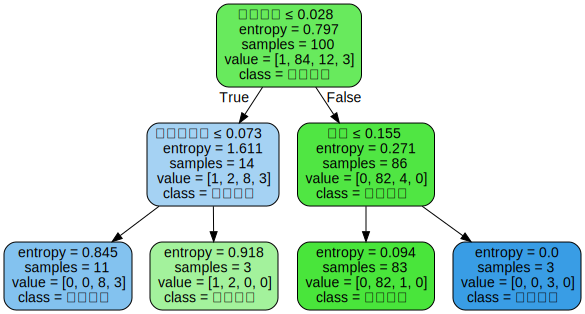

In [263]:
import graphviz
dot_data = tree.export_graphviz(dt_clf1,
                                out_file=None,
                                feature_names=tfidf.get_feature_names(),
                                class_names=["미정","소상공인","연구기관","중소기업"],
                                filled=True,
                                rounded=True,
                                special_characters=True)  
graph = graphviz.Source(dot_data)
graph

In [11]:
import os
os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin/"

In [25]:
da = pd.read_excel("./process1383.xlsx",index=False)

In [117]:
data3 = da.sample(300,random_state=2020).reset_index()
data4 = da.sample(300,random_state=2020).reset_index()

In [27]:
c = []
#바로 형태소단위로 나누면 빈문장이 생기고 단어의 길이가 1개인 문장이 생기는 문제점이 발생하기에
#본문내용을 문장단위로 나눈다음에 Hannum 형태소 분석기를 이용하겠습니다.
for i in tqdm(range(len(data3))):
    #공고문 본문안에서 필요없는 내용 제외합니다.
    b = re.sub("[\n]+","\n",data3["파일내용"][i])
    b = re.sub("[  ]+"," ",b)
    b = re.sub("[<표>|<그림>]+"," ",b)
    b = b.strip()
    #본문내용을 문장단위로 나누어 리스트형태로 저장합니다.
    b = b.split("\n")
    #문장단위로 나누면서 생기는 빈문장을 제거합니다.
    c = [x.strip() for x in b if x != ' ']
    #문장내에서 한글을 제외한 요소를 제거하고 각 문장마다 형태소 분석기를 사용합니다.
    aaa0 = list(map(lambda x: re.sub("[^ ㄱ-ㅣ가-힣]+"," ",x),c))
    aaa0 = [x.strip() for x in aaa0 if x != '']
    aaa0 = [okt.morphs(x) for x in aaa0]
    sum0 = sum(aaa0,[])
    #형태소 분석결과 나온 단어들중에서 단어의 길이가 1보다 작은건 빼겠습니다.
    sum0 = [x for x in sum0 if len(x) > 1]
    sum00 = " ".join(sum0)
    #전처리가 끝난 공고내용을 다시 dataframe에 저장하겠습니다.
    data3["파일내용"][i] = sum00

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]C:\Users\park\Anaconda3\envs\crawler\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [04:05<00:00,  1.22it/s]


In [139]:
X3 = tfidf.fit_transform(data3["파일내용"]).toarray()

In [158]:
p_X = dt_clf1.predict(X3)
lab_enc.inverse_transform(p_X)

array(['소상공인', '중소기업', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인',
       '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '연구기관', '소상공인',
       '소상공인', '중소기업', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '중소기업',
       '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '중소기업', '소상공인', '연구기관',
       '연구기관', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '연구기관',
       '소상공인', '소상공인', '연구기관', '중소기업', '소상공인', '소상공인', '소상공인', '연구기관',
       '연구기관', '소상공인', '중소기업', '소상공인', '소상공인', '소상공인', '소상공인', '중소기업',
       '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인',
       '중소기업', '소상공인', '중소기업', '소상공인', '연구기관', '중소기업', '연구기관', '소상공인',
       '중소기업', '소상공인', '소상공인', '소상공인', '소상공인', '연구기관', '소상공인', '소상공인',
       '중소기업', '중소기업', '중소기업', '소상공인', '소상공인', '중소기업', '소상공인', '소상공인',
       '중소기업', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인',
       '연구기관', '소상공인', '소상공인', '소상공인', '중소기업', '연구기관', '중소기업', '소상공인',
       '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인', '소상공인',
      

In [159]:
pd.Series(lab_enc.inverse_transform(p_X)).value_counts()

소상공인    217
중소기업     48
연구기관     35
dtype: int64

In [165]:
np.where(p_X == 2 )

(array([ 14,  31,  32,  39,  42,  47,  48,  68,  70,  77,  96, 101, 124,
        135, 150, 154, 157, 159, 168, 175, 195, 196, 206, 212, 216, 224,
        226, 250, 254, 266, 267, 276, 286, 288, 296], dtype=int64),)

In [166]:
k = 14
re.search("과제",data4["파일내용"][k])

<re.Match object; span=(35, 37), match='과제'>

In [164]:
print(data4["파일내용"][k][:3025])
#'    소: 연 락 처: \n\n\n  한국장례문화진흥원이 추진'


<표>


용역 수의계약 견적제출 안내 공고
 
  
1. 견적제출에 부치는 사항  
   가. 용 역 명 : 2030 김해시 환경보전계획 수립 연구용역
   
나. 용역개요 : 환경보전계획 수립용역 1식
   다. 용역기간 : 착수일로부터 240일
   라.



 용 역 비 : 금54,760,000원(금오천사백칠십육만원) ※ 부가세포함
   
마. 기초금액 : 금54,760,000원(금오천사백칠십육만원)
    ※ 상기 기초금액은 부가세가 포함된 금액으로 입찰참여 업체는 부가세를  포함한 가격으로 입찰하여야 하며, 면세사업자는 낙찰금액에서 부가세를 제외한 금액으로 계약 체결합니다.     
    ※ 상세 내역은 용역감독관과 상의하시기(표혜진, 055-330-2445) 바라며, 투찰 전 설계서(시방서)등을 반드시 확인(열람)후 응찰하고, 확인하지 아니하여 발생하는 책임은 투찰자에게 있습니다.

2. 견적서 제출기간 : 2020. 4. 27.(월) 16:00 ~ 5. 4.(월) 16:00
   ※ 투찰마감시간이 임박하여 투찰할 경우 여러 업체의 집중 투찰로 인하여 정상적인        투찰이 불가한 경우가 종종 발생되오니 가급적 투찰마감 2시간 이전에 투찰하시기        바랍니다.

3. 개찰일시 및 장소 : 2020. 5. 4.(월) 17:00 이후 우리시 입찰집행관 PC

4. 견적제출자 참가자격
  가. 지방자치단체를 당사자로 하는 계약에 관한 법률 시행령 제13조 및 동법 시행규칙 제14조의 규정에 따른 자격요건을 갖춘 업체이어야 하며, 입찰공고일 전일 현재 법인등기부상 본점 소재지(개인사업자인 경우에는 사업자등록증 또는 관련 법령에 따른 허가․인가․면허․등록․신고 등에 관련된 서류에 기재된 사업장의 소재지)가 경상남도이어야 하고, 입찰일(낙찰자는 계약일)까지 당해 자격을 유지하여야 합니다.
나.「국가종합전자조달시스템 입찰참가자격등록규정」에 의하여 반드시 나라장터(G2B)에 입찰서 제출 마감일 전일까지 학술․연구용역기관(업종코드:1169)으로 입

In [126]:
!python --version

Python 3.7.3
